# Pretrained models
So far we used random weights and parameters to visualise the image through filters. Let us now use a pretrained model to visualise the image through learned filters. We will use the resnet18 model which is pretrained on the ImageNet dataset.

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchsummary # pretty print of torch models

#import json
import urllib.request

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [48]:
# load a sample image
img = Image.open("car.jpg").convert("RGB")

# resnet expects RGB images not a tensor.

In [47]:
# Load the pretrained model
resnet = models.resnet18(pretrained=True).eval().to(device)
torchsummary.summary(resnet, input_size=(3, 224, 224), device=device) # pretty printing of the network

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

/home/ir-shar8/disruption/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ir-shar8/disruption/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This shows four layer modules and one fc module. We can print them in a nicer way.

In [41]:
for name, module in resnet.named_modules():
    print(name, "→", module.__class__.__name__)

 → ResNet
conv1 → Conv2d
bn1 → BatchNorm2d
relu → ReLU
maxpool → MaxPool2d
layer1 → Sequential
layer1.0 → BasicBlock
layer1.0.conv1 → Conv2d
layer1.0.bn1 → BatchNorm2d
layer1.0.relu → ReLU
layer1.0.conv2 → Conv2d
layer1.0.bn2 → BatchNorm2d
layer1.1 → BasicBlock
layer1.1.conv1 → Conv2d
layer1.1.bn1 → BatchNorm2d
layer1.1.relu → ReLU
layer1.1.conv2 → Conv2d
layer1.1.bn2 → BatchNorm2d
layer2 → Sequential
layer2.0 → BasicBlock
layer2.0.conv1 → Conv2d
layer2.0.bn1 → BatchNorm2d
layer2.0.relu → ReLU
layer2.0.conv2 → Conv2d
layer2.0.bn2 → BatchNorm2d
layer2.0.downsample → Sequential
layer2.0.downsample.0 → Conv2d
layer2.0.downsample.1 → BatchNorm2d
layer2.1 → BasicBlock
layer2.1.conv1 → Conv2d
layer2.1.bn1 → BatchNorm2d
layer2.1.relu → ReLU
layer2.1.conv2 → Conv2d
layer2.1.bn2 → BatchNorm2d
layer3 → Sequential
layer3.0 → BasicBlock
layer3.0.conv1 → Conv2d
layer3.0.bn1 → BatchNorm2d
layer3.0.relu → ReLU
layer3.0.conv2 → Conv2d
layer3.0.bn2 → BatchNorm2d
layer3.0.downsample → Sequential
layer3.

So, in total, we have 5 modules in the resnet18 model. This makes writing the forward pass a bit more easy. We can just call the forward method of each module in the order they are present in the model.

## Preprocess image for resnet18
The resnet18 model expects the input image to be of size 224x224. We will preprocess the image to be of this size.

In [13]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                std=[0.229, 0.224, 0.225])
])

In [14]:
img_resnet = transform(img).unsqueeze(0).to(device)  # (1, 3, 224, 224)
print(img_resnet.shape)

torch.Size([1, 3, 224, 224])


## Output from the first layer of the resnet18 model
Let us only use the first layer of the resnet18 model to visualise the image through the filters.

In [15]:
# we will use this plotting function multiple times, so let us make a function
import matplotlib.pyplot as plt

def visualize_feature_maps(tensor, fig_num, title_prefix="Channel"):
    """
    Plots the first `max_channels` feature maps from a 4D tensor of shape (1, C, H, W).
    This is very hardcoded function, don't try fancy things.
    """
    plt.figure(fig_num)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i in range (8): # 8 out_channels
        axs[i//4, i%4].imshow(tensor[0, i].cpu().numpy(), cmap='gray') # i is looping over each output channel
        axs[i//4, i%4].set_title(title_prefix +"  " + str(i+1)) # i+1 because i starts from 0
        axs[i//4, i%4].axis('off')
    plt.tight_layout()

In [ ]:
with torch.no_grad():
    x = resnet.conv1(img_resnet)     # (1, 64, 112, 112)
    x = resnet.bn1(x)
    x = resnet.relu(x)

In [ ]:
x.shape # there are 64 output channels, we can't visualize all of them. We will visualize only 8 of them

torch.Size([1, 64, 112, 112])

<Figure size 640x480 with 0 Axes>

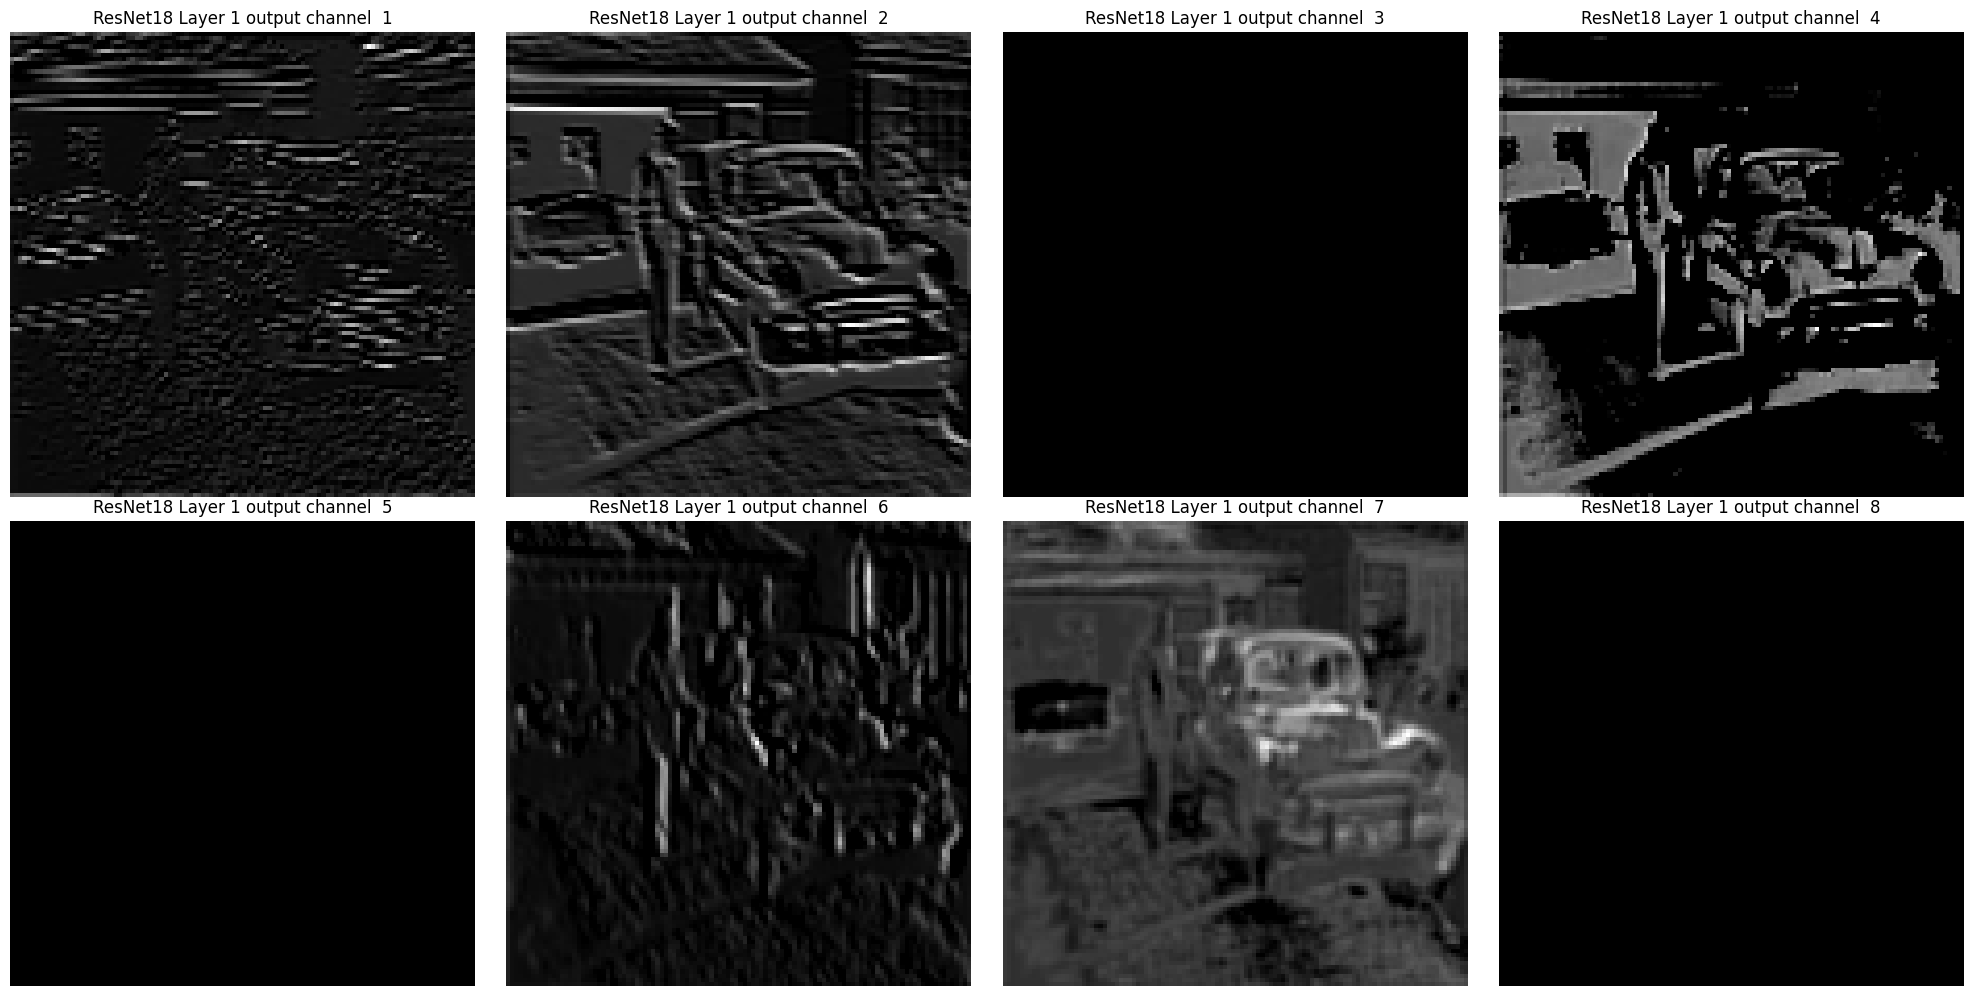

In [23]:
visualize_feature_maps(x, 1, title_prefix="ResNet18 Layer 1 output channel")

Please note that there are 64 filters in the first layer of the resnet18 model. We will visualise the first 8 filters. The output from the 1st layer is very vague and shows the in some corners in image 2 and 4. 

Let us see if we see something different when we use the first two layers of resnet18 model.

## Output from the first two layer of the resnet18 model

In [24]:
with torch.no_grad():
    x = resnet.conv1(img_resnet)
    x = resnet.bn1(x)
    x = resnet.relu(x)
    x = resnet.maxpool(x)

    x1 = resnet.layer1(x)  # (1, 64, 56, 56)
    x2 = resnet.layer2(x1) # (1, 128, 28, 28)


In [26]:
x2.shape # there are 128 output channels, we can't visualize all of them. We will visualize only 8 of them

torch.Size([1, 128, 28, 28])

<Figure size 640x480 with 0 Axes>

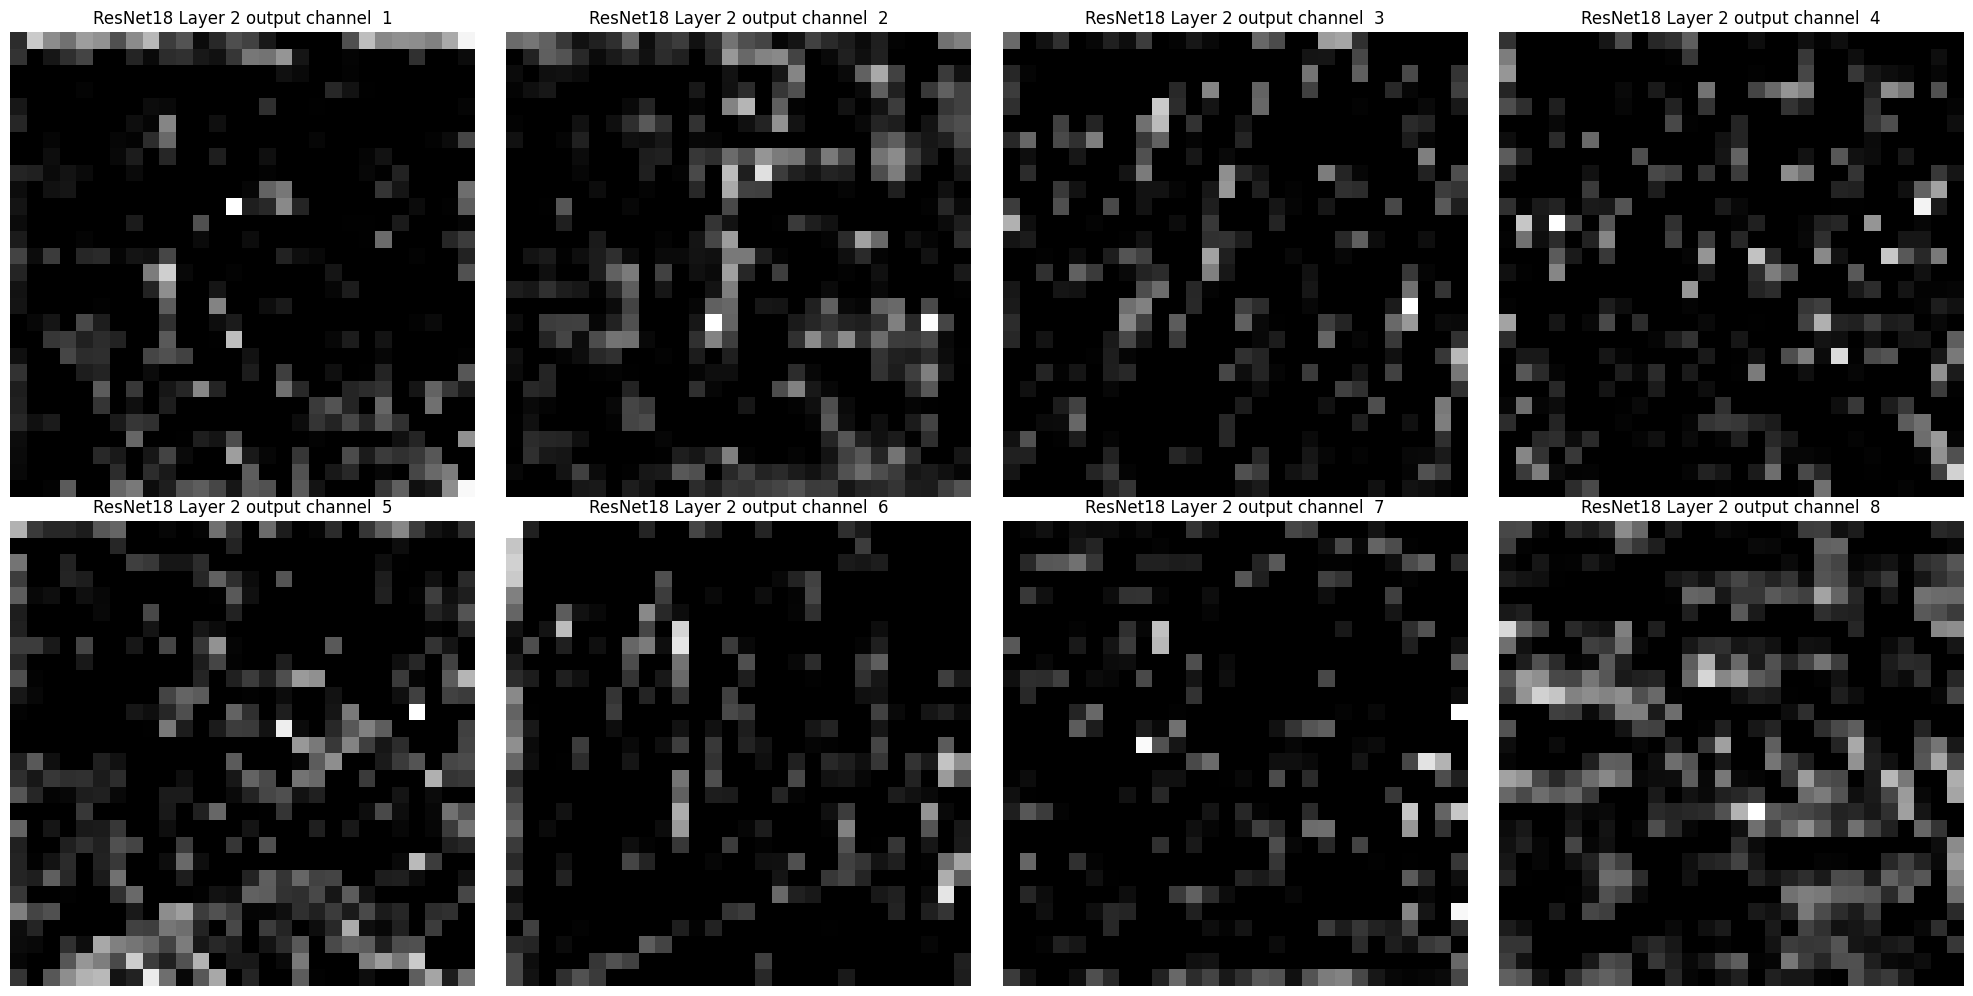

In [27]:
visualize_feature_maps(x2, 2, title_prefix="ResNet18 Layer 2 output channel")

That’s deep learning for you. The deeper you go, the blurrier it looks. These deep layers aren’t meant to be interpretable to humans. They're abstract high-dimensional features for the regressor or classifier. That is why interpretability is a big challenge in deep learning. The day we can know the meaning of these weird intermediate outputs will be able to do some cool stuff.

## Trying full resnet18 model

<Figure size 640x480 with 0 Axes>

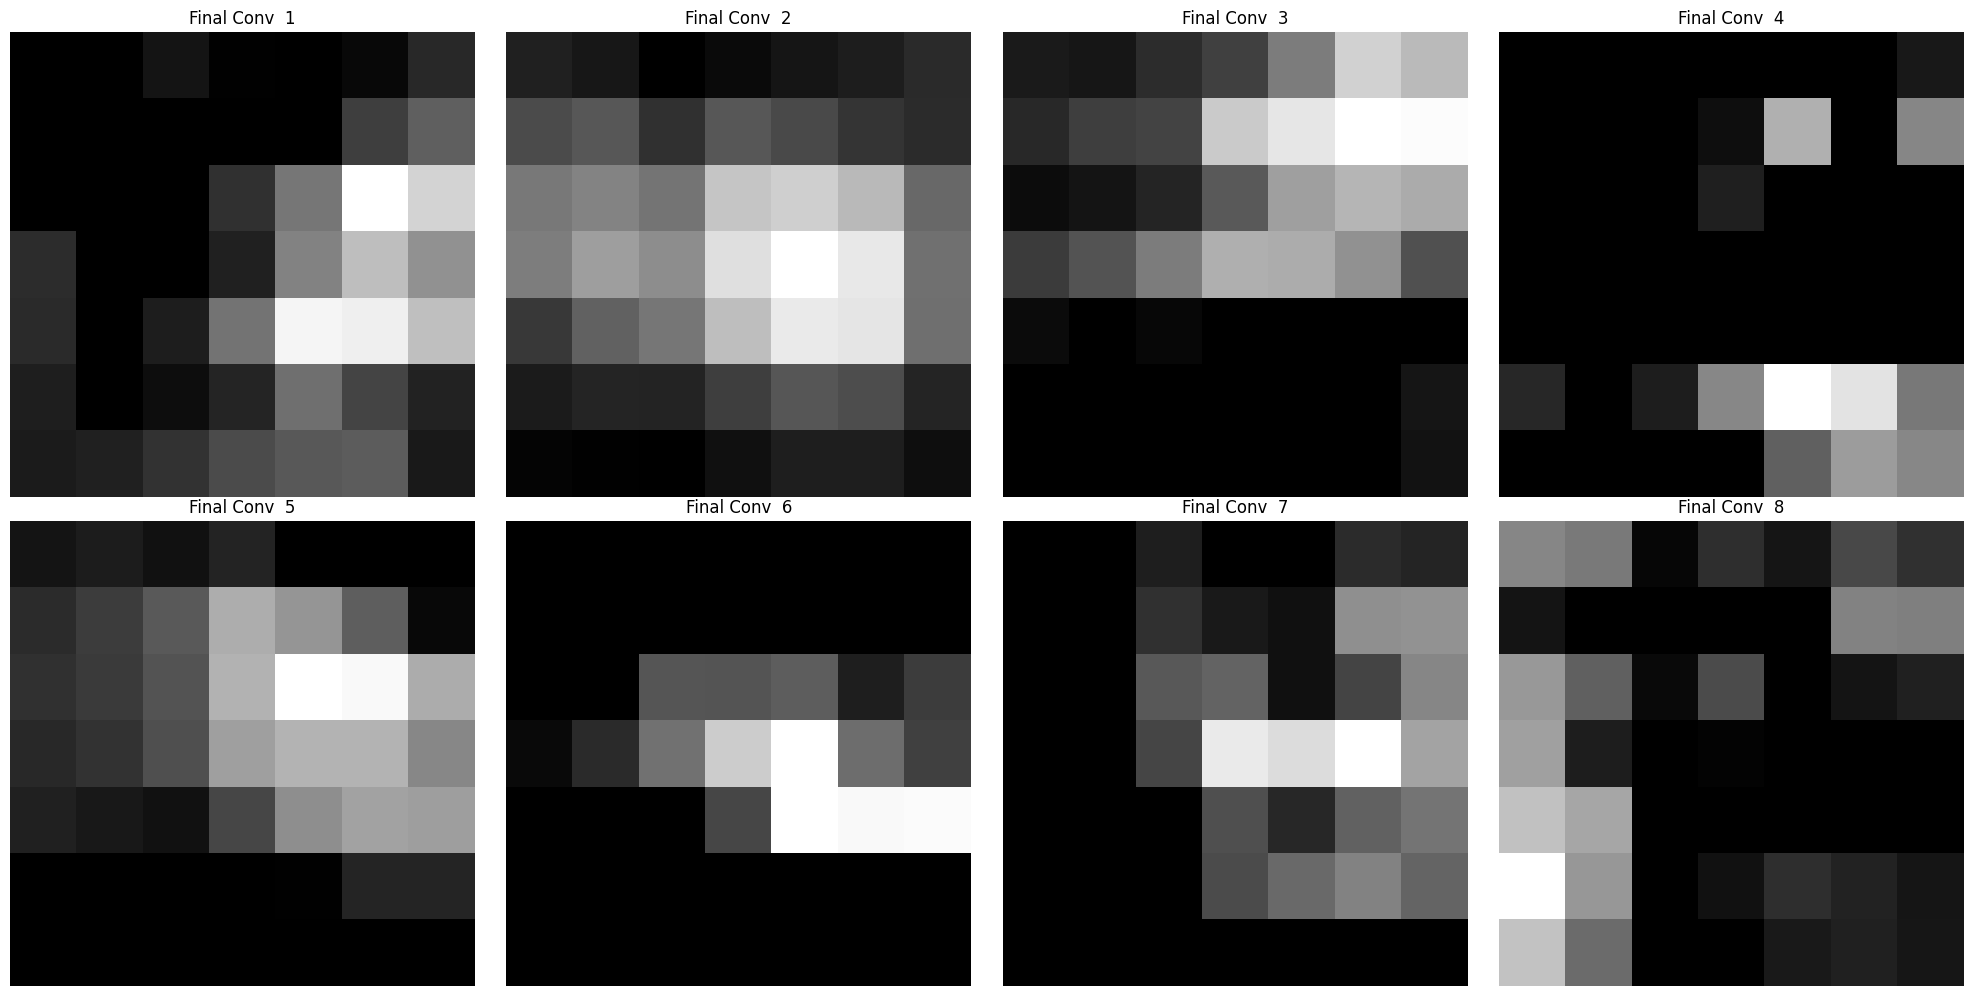

In [ ]:
with torch.no_grad():
    # resnet18 has 4 layer modules
    x = resnet.conv1(img_resnet)
    x = resnet.bn1(x)
    x = resnet.relu(x)
    x = resnet.maxpool(x)
    
    x = resnet.layer1(x)
    x = resnet.layer2(x)
    x = resnet.layer3(x)
    x = resnet.layer4(x)      # [1, 512, 7, 7]
    visualize_feature_maps(x, 3, title_prefix="Final Conv")

    x_avg = resnet.avgpool(x) # [1, 512, 1, 1]
    x_flat = torch.flatten(x_avg, 1)  # [1, 512]
    x_logits = resnet.fc(x_flat)      # [1, 1000] # output of resnet18


Even more vague. Let us leave it here.
# Classify our image

## Resnet18 model
The resnet18 model is pretrained on the ImageNet dataset. Its basic task was to classify the images into 1000 classes. Let us use the resnet18 model to classify our image and see accurate it is. Remember, the input image was a random image and not from the ImageNet dataset. Also, it was a low-resolution image. So, we should not expect the model to classify it accurately.

The first thing we need to do is download the list of class labels for the ImageNet dataset. We will then use the resnet18 model to classify our image and see the top 5 class labels predicted by the model. These class labels are stored in the PyTorch's Hub repo, [here](https://github.com/pytorch/hub/blob/master/imagenet_classes.txt).

In [ ]:
# Download the txt file with human-readable labels
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
filename = "imagenet_classes.txt"
urllib.request.urlretrieve(url, filename)

# Load labels
with open(filename) as f:
    labels = [line.strip() for line in f.readlines()] # read all labels line by line


In [ ]:
probs = F.softmax(x_logits, dim=1) # passing the 1000 fc output through softmax to get the probabilities for 1000 classes in the text file
top5 = torch.topk(probs, 5) # get the top 5 probabilities and their indices

In [ ]:
for i in range(5):
    class_id = top5.indices[0][i].item() # get the index of the top 5 classes
    score = top5.values[0][i].item() # get the score of the top 5 classes
    print(f"{i+1}. {labels[class_id]} ({score:.4f})")


1. minivan (0.2755)
2. moving van (0.1068)
3. beach wagon (0.0951)
4. minibus (0.0941)
5. pickup (0.0884)
